### Todo
- short time interval graph generation - done
- clean and improve data - done

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import geopandas as gpd
from shapely.geometry import Point
import pyproj
#pyproj.datadir.set_data_dir('/usr/local/share/proj')
from pyproj import CRS, Transformer
import folium

In [2]:
# this script is create by A. Biricz, ?.12.2020.
# Arguments:
# --source_folder
# --target_folder

# Add command line arguments

import numpy as np
import pandas as pd
from itertools import product
import os
from tqdm import tqdm
#from tqdm import tqdm_notebook as tqdm

# Locate files
source = '/media/Data_storage/Mobilcell/Data/'
target = '/media/Data_storage/Mobilcell/DayEventData/'
source_pol = '/media/Data_storage/Mobilcell/DayPolygonData/'

files_events = np.array( sorted([ i for i in os.listdir(source) if 'EVENTS' in i]) )
files_poligons = np.array( sorted([ i for i in os.listdir(source) if 'POLIGONS' in i]) )
files_events_cleaned = np.array( sorted([ i for i in os.listdir(source) if 'Events' in i]) )

In [3]:
poligons_path = files_poligons[100]
events_path = files_events[100]

# load data
print("loading input data")
poligons_df = pd.read_csv( source+poligons_path, delimiter=';' )
events_df = pd.read_csv( source+events_path, delimiter=';' )

loading input data


In [4]:
# drop poligons outside of the country
poligons_df = poligons_df[ np.logical_and( poligons_df.eovx.values < 366660, 
                                           poligons_df.eovx.values > 48210 ) ]
poligons_df = poligons_df[ np.logical_and( poligons_df.eovy.values < 934219, 
                                           poligons_df.eovy.values > 426341 ) ]

# load global, fix tower data
towers_df = pd.read_csv( source_pol+'fixed_tower_locations.csv' )

# calculate tower encodings
tower_id = np.unique( towers_df.original_id.values )
tower_to_int = dict( zip( towers_df.original_id.tolist(), towers_df.tower_id.tolist() ) )

tower_coords_all = dict( zip( towers_df.values[:,1].tolist(), towers_df.values[:,2:4].tolist() ) )

# add encodings to the dataframes
print("encode ids of towers and events")
poligons_df["tower_idx"] = [ tower_to_int[i] for i in poligons_df.network_identifier.values ]
events_df["tower_idx"] = [ tower_to_int[i] for i in events_df.network_identifier.values ]

# calculate event (equipment id) encodings
event_id = np.unique( events_df.equipment_identifier.values )
event_to_int = dict(zip( event_id, np.arange(event_id.shape[0]) ))

# add event encodings to the dataframes
events_df["event_idx"] = [ event_to_int[i] for i in events_df.equipment_identifier.values ]

# partitioning the event dataframe to track individual events
eq_diff_idx = np.where( np.diff(events_df.event_idx.values) )[0]+1
# insert first element (zero) ## otherwise left out!
eq_diff_idx = np.insert(eq_diff_idx, 0, 0, axis=0)
# insert last element (size of array) ## otherwise left out!
eq_diff_idx = np.append( eq_diff_idx, events_df.event_idx.values.shape[0] )

# calculate trajectories of events (to which tower it connects to and when)
eq_trajectories_towers = []
eq_trajectories_time = []
print("calculate trajectories of events..")
for i in tqdm( range( eq_diff_idx.shape[0]-1 ) ):
    start_ = eq_diff_idx[i]
    end_ = eq_diff_idx[i+1]
    eq_trajectories_towers.append( events_df.tower_idx.values[ start_:end_ ] )
    eq_trajectories_time.append( events_df.event_datetime.values[ start_:end_ ] )

# these arrays holds the information about the events
eq_trajectories_towers = np.array( eq_trajectories_towers ) # array of variable length arrays!
eq_trajectories_time = np.array( eq_trajectories_time ) # array of variable length arrays!

# check for unique values and drop events that stand still for the whole day
eq_trajectories_towers_uq = np.array([ np.shape(np.unique(i))[0] for i in eq_trajectories_towers ])
eq_trajectories_time = eq_trajectories_time[ eq_trajectories_towers_uq > 1 ]
eq_trajectories_towers = eq_trajectories_towers[ eq_trajectories_towers_uq > 1 ]

# load datetime variable to code time as minutes
dates_clock = np.loadtxt( "event_datetime.csv").astype(int) # time on clock
dates_time = np.arange( 1440 ) # time in sec
time_to_sec = dict( zip(dates_clock, dates_time) )

encode ids of towers and events


  0%|          | 9591/4259594 [00:00<00:44, 95908.72it/s]

calculate trajectories of events..


100%|██████████| 4259594/4259594 [00:45<00:00, 94466.42it/s]


### Investigate how event trajectories can be improved

In [8]:
eq_trajectories_towers.shape

(3383565,)

In [9]:
eq_trajectories_towers[0]

array([40003,  8071, 12328,  4068,  4068,  4068, 39517, 42998, 42998,
        5935])

In [10]:
eq_trajectories_time[0]

array([ 158,  710,  718,  721,  721,  721, 1400, 1824, 1824, 1828])

In [11]:
## PART 1:

eq_info_all = np.zeros( ( np.sum([ len(i) for i in eq_trajectories_towers ]), 11 ), 
                        dtype=np.int32 )
counter = 0
eps = 1e-6 # add small time to avoid division by zero
for curr in tqdm( range( eq_trajectories_towers.shape[0] ) ):
    #print(curr)
    
    # get indices
    eq_path = np.vstack( (eq_trajectories_towers[curr][:-1], eq_trajectories_towers[curr][1:]) ).T
    
    # filter if source and destination is the same
    filt = (eq_path[:,0] != eq_path[:,1])
    eq_path = eq_path[filt]
    
    # get time in minutes format
    eq_time_ = np.array( list( map(time_to_sec.get, eq_trajectories_time[curr]) ) )
    eq_time_min = eq_time_[1:] - eq_time_[:-1]
    eq_time_min = eq_time_min[filt] / 60 # this becomes hour for calc speed!
    eq_time_ = eq_time_[:-1][filt]
    
    src_coords = np.array([ tower_coords_all[ m ] for m in eq_path[:,0] ])
    dst_coords = np.array([ tower_coords_all[ n ] for n in eq_path[:,1] ])
    
    eq_dist_km = np.sqrt( np.sum( ( dst_coords - src_coords )**2, 1 ) ) / 1000
    
    eq_speed_kmh = (eq_dist_km/eq_time_min+eps).astype(int)
    filt = np.logical_and( eq_speed_kmh > 3, eq_speed_kmh < 180 )
    
    # saving calculated trajectory
    #eq_info = pd.DataFrame( 
    eq_info = np.concatenate( (
                        curr*np.ones( filt.sum(), dtype=np.int32).reshape(-1,1),
                        eq_time_[filt].reshape(-1,1), 
                        src_coords[filt],
                        dst_coords[filt],
                        eq_time_min[filt].reshape(-1,1)*60,
                        eq_dist_km[filt].reshape(-1,1)*1000, 
                        eq_speed_kmh[filt].reshape(-1,1)/3.6,
                        eq_path[:,0][filt].reshape(-1,1),
                        eq_path[:,1][filt].reshape(-1,1) ), axis=1).astype(int) #,
#columns=['id',start_time_min','src_x','src_y','dst_x', 'dst_y','trip_time_min', 'dist_m', 'speed_ms'])
    
    for l in range(eq_info.shape[0]):
        eq_info_all[counter] = eq_info[l]
        counter += 1

# drop not needed elements from the end of the array
eq_info_all = eq_info_all[:counter]

## PART 2:

# events that last longer than 30 minutes could be further processed
filt_long_trips = eq_info_all[:, 6 ] > 30 # 6th index means time
eq_info_all_long = eq_info_all[ filt_long_trips ]

# first remove these longer events from the list
eq_info_all = eq_info_all[ ~filt_long_trips ]

  0%|          | 0/3383565 [00:00<?, ?it/s]/home/abiricz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/abiricz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 3383565/3383565 [07:18<00:00, 7709.65it/s]


In [38]:
eq_info_all[:5].shape

(5, 11)

In [21]:
savename = target + 'output_daily-events-data_' + events_path.split('.csv')[0][-8:]+'.csv.gz'
savename

'/media/Data_storage/Mobilcell/DayEventData/output_daily-events-data_20190311.csv.gz'

In [22]:
%%time
np.save( target + 'output_daily-events-data_' + events_path.split('.csv')[0][-8:],
         eq_info_all )

CPU times: user 231 ms, sys: 585 ms, total: 816 ms
Wall time: 4.34 s


In [24]:
eq_info_final = np.load( target + 'output_daily-events-data_' + events_path.split('.csv')[0][-8:]+'.npy'  )

In [25]:
eq_info_final.shape

(18488000, 11)

#### Gain in events number after interpolation: 21.426.372 --> 39.234.054

((21426373, 9), (6516431, 9), 21426373)

In [26]:
eq_info_all.shape, eq_info_all_long.shape, 14909942+6516431

((18488000, 11), (2933875, 11), 21426373)

In [17]:
eq_info_final = eq_info_all

### Visualization on map

#### Filter for 15 minutes range

In [27]:
eq_to_map = eq_info_final[ np.in1d( eq_info_final[:,1], np.arange(600, 630) ) ]
eq_to_map.shape, eq_to_map[:3]

((672974, 11),
 array([[     7,    603, 223648, 659898, 225576, 661270,      3,   2366,
             13,    805,    574],
        [     7,    622, 225576, 661270, 223648, 659898,      8,   2366,
              4,    574,    805],
        [    26,    625, 242483, 646046, 243007, 646164,      5,    537,
              1,   1172,   2059]], dtype=int32))

#### Filter out motions that takes longer than 15 minutes!

(670958, 9)

In [28]:
eq_to_map = eq_to_map[ eq_to_map[:,6] < 31 ]
eq_to_map.shape

(672974, 11)

In [29]:
eq_path_map = np.array([ np.array( (eq_to_map[i,2:4], eq_to_map[i,4:6]) ) for i in range(eq_to_map.shape[0]) ])
eq_path_map[:3], eq_path_map.shape

(array([[[223648, 659898],
         [225576, 661270]],
 
        [[225576, 661270],
         [223648, 659898]],
 
        [[242483, 646046],
         [243007, 646164]]], dtype=int32), (672974, 2, 2))

In [30]:
eq_mapping = np.zeros(eq_path_map.shape, dtype=np.float32)
eq_mapping.shape

(672974, 2, 2)

In [31]:
crs_eov = CRS.from_epsg("23700")
crs_lonlat = CRS.from_epsg("4326")
transformer = Transformer.from_crs(crs_eov, crs_lonlat)

In [32]:
 transformer.transform( eq_path_map[0,:,1], eq_path_map[0,:,0] )

(array([47.35677347, 47.37409403]), array([19.17847194, 19.19668197]))

In [33]:
eq_path_map[30,1,:]

array([251907, 637545], dtype=int32)

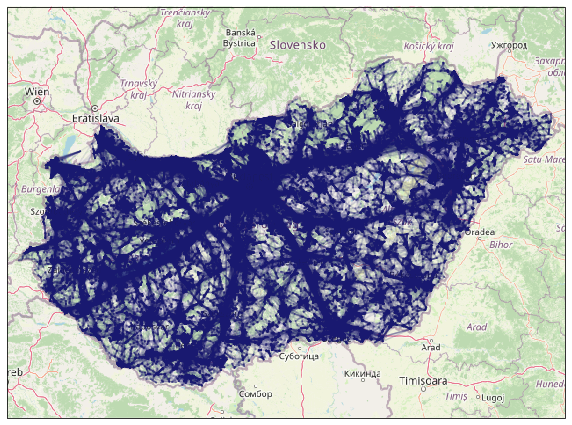

In [37]:
crs_eov = CRS.from_epsg("23700")
crs_lonlat = CRS.from_epsg("4326")
transformer = Transformer.from_crs(crs_eov, crs_lonlat)

# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.OSM() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 8 is a layer num, higher means more detail

eq_mapping[:,0,:], eq_mapping[:,1,:] = transformer.transform( xx=eq_path_map[:,:,1],
                                                              yy=eq_path_map[:,:,0] )

xynps = ax.projection.transform_points( ccrs.Geodetic(), 
                                        x=eq_mapping[:,1,:], 
                                        y=eq_mapping[:,0,:])
xynps = np.swapaxes(xynps[:,:,:-1], 1, 2)

for i in range( xynps.shape[0] ):
    plt.plot( xynps[i,0], xynps[i,1], alpha=0.1, color='midnightblue' )
plt.savefig('motion_snapshot_30_minutes.png', dpi=100)

#### To-do:
- mark time bins the given equipment gives contribution into
- 